# MaxPooling, Batch Normalization și Upsampling/Deconvolution în CNN (PyTorch)

## 0) Setări & importuri

In [1]:
import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

torch.manual_seed(0)
np.random.seed(0)

def show_pair_native(input_2d, output_2d, title_in='Input', title_out='După op'):
    if torch.is_tensor(input_2d): inp = input_2d.detach().cpu().numpy()
    else: inp = np.asarray(input_2d)
    if torch.is_tensor(output_2d): out = output_2d.detach().cpu().numpy()
    else: out = np.asarray(output_2d)

    fig = plt.figure(figsize=(8,4))
    gs = fig.add_gridspec(1, 2, width_ratios=[2.2, 1.0])
    ax1 = fig.add_subplot(gs[0,0]); ax2 = fig.add_subplot(gs[0,1])
    ax1.imshow(inp, cmap='gray'); ax1.set_title(title_in); ax1.axis('off')
    ax2.imshow(out, cmap='gray'); ax2.set_title(title_out); ax2.axis('off')
    plt.tight_layout(); plt.show()

print('PyTorch', torch.__version__)

PyTorch 2.8.0+cu126


## 1) MaxPool

**Pooling-ul** este o operație folosită în rețelele convoluționale pentru a **reduce dimensiunea spațială** a feature map-urilor, păstrând în același timp informațiile esențiale.

Cel mai frecvent tip este **MaxPooling**, care reduce rezoluția spațială (H, W) păstrând valorile maxime pe ferestre.  
Astfel:
- reduce costul computațional,
- oferă o formă de *invarianță la translație* (rețeaua devine mai puțin sensibilă la poziția exactă a trăsăturilor),
- contribuie la regularizare (reduce overfitting-ul).
- Alte tipuri importante de pooling: AveragePooling
- Parametrii principali: kernel_size, stride, padding

- În PyTorch: `nn.MaxPool2d(kernel_size, stride)`.
- De obicei: `kernel_size=2, stride=2` → înjumătățește H și W.

### Resurse:
- [Max Pooling Pytorch Documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)
- [Average Pooling Pytorch Documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html)
- [Pooling Operations](https://www.geeksforgeeks.org/deep-learning/cnn-introduction-to-pooling-layer/)
- [Pooling Operations 2](https://www.geeksforgeeks.org/deep-learning/cnn-introduction-to-pooling-layer/)
- [https://cs231n.github.io/convolutional-networks/](https://cs231n.github.io/convolutional-networks/#pool)


In [2]:
def img_checker(size=64, block=8):
    t = torch.zeros(size, size)
    for y in range(size):
        for x in range(size):
            t[y, x] = 1.0 if ((y // block + x // block) % 2 == 0) else 0.0
    return t

def img_gradient(size=64):
    y = torch.linspace(0, 1, size).view(size, 1).repeat(1, size)
    return y

# --- New interesting shapes/patterns ---

def img_square(size=64, sq=24, top_left=(6, 6), val=1.0):
    t = torch.zeros(size, size)
    y0, x0 = top_left
    t[y0:y0+sq, x0:x0+sq] = val
    return t

def img_circle(size=64, radius=12, center=None):
    if center is None:
        center = (size // 2, size // 2)
    cy, cx = center
    yy, xx = torch.meshgrid(torch.arange(size), torch.arange(size), indexing='ij')
    dist = torch.sqrt((yy - cy) ** 2 + (xx - cx) ** 2)
    t = (dist <= radius).float()
    return t

def img_lines(size=64, orientation='vertical', period=6):
    t = torch.zeros(size, size)
    for i in range(size):
        if orientation == 'vertical':
            if (i // period) % 2 == 0:
                t[:, i] = 1.0
        else:
            if (i // period) % 2 == 0:
                t[i, :] = 1.0
    return t

def img_sparse_noise(size=64, p=0.08):
    t = torch.zeros(size, size)
    mask = torch.rand(size, size) < p
    t[mask] = 1.0
    return t

def img_border(size=64, thickness=2):
    t = torch.zeros(size, size)
    t[:thickness, :] = 1.0
    t[-thickness:, :] = 1.0
    t[:, :thickness] = 1.0
    t[:, -thickness:] = 1.0
    return t

def img_diag_stripes(size=64, period=8):
    # Diagonal stripes via (x+y) // period
    t = torch.zeros(size, size)
    yy, xx = torch.meshgrid(torch.arange(size), torch.arange(size), indexing='ij')
    t[((yy + xx) // period) % 2 == 0] = 1.0
    return t

# Collect a diverse set
imgs = {
    'Checker': img_checker(),
    'Gradient': img_gradient(),
    'Square TL': img_square(64, sq=20, top_left=(6, 6)),
    'Circle center': img_circle(64, radius=12),
    'Lines vertical': img_lines(64, 'vertical', period=6),
    'Lines horizontal': img_lines(64, 'horizontal', period=6),
    'Sparse noise': img_sparse_noise(64, p=0.08),
    'Border': img_border(64, thickness=2),
    'Diag stripes': img_diag_stripes(64, period=8),
}

[Checker] input=(64, 64) -> pooled=(32, 32)


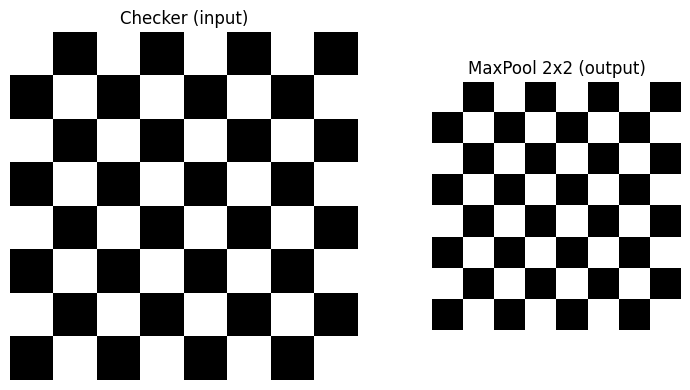

[Gradient] input=(64, 64) -> pooled=(32, 32)


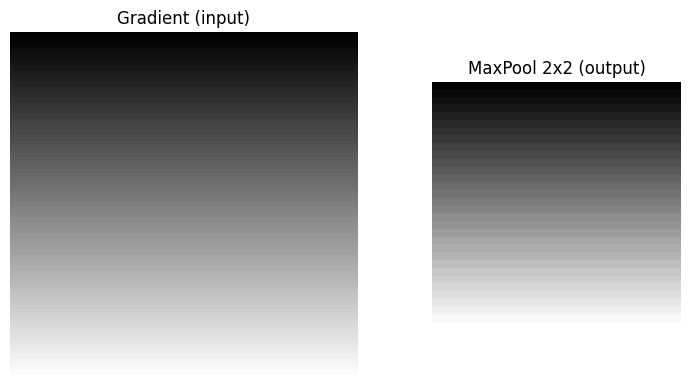

[Square TL] input=(64, 64) -> pooled=(32, 32)


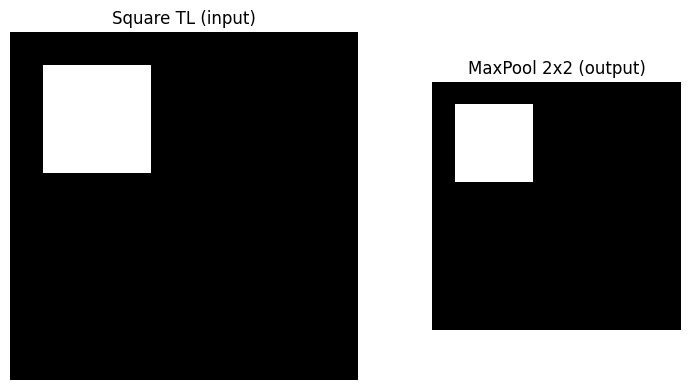

[Circle center] input=(64, 64) -> pooled=(32, 32)


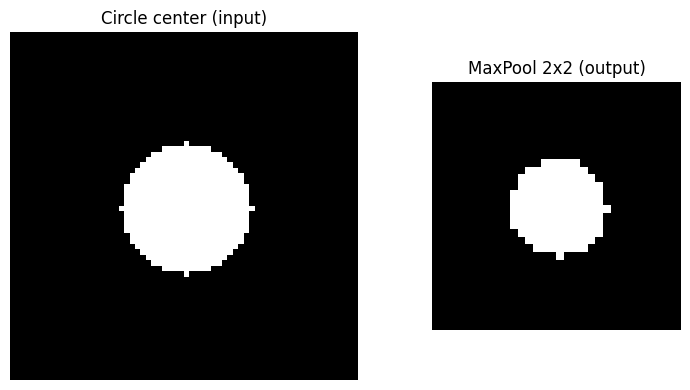

[Lines vertical] input=(64, 64) -> pooled=(32, 32)


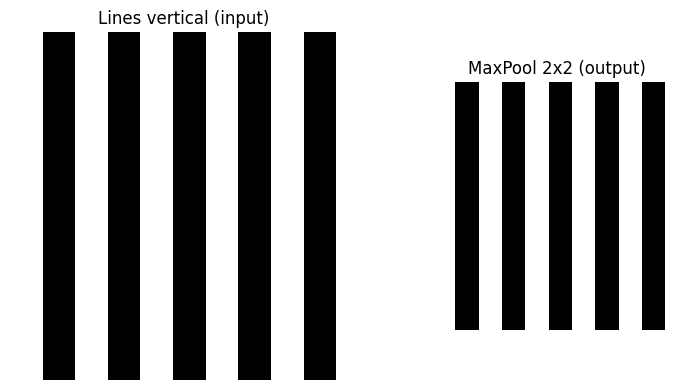

[Lines horizontal] input=(64, 64) -> pooled=(32, 32)


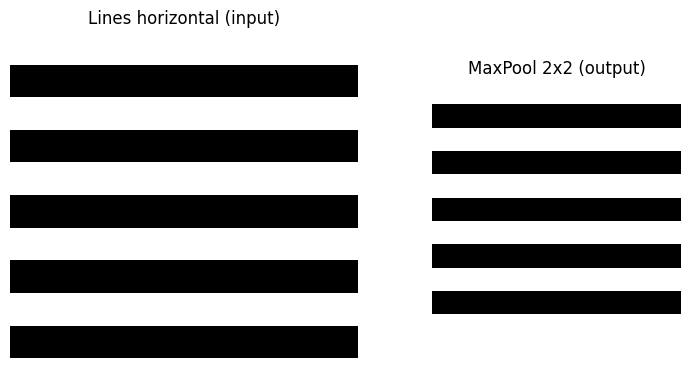

[Sparse noise] input=(64, 64) -> pooled=(32, 32)


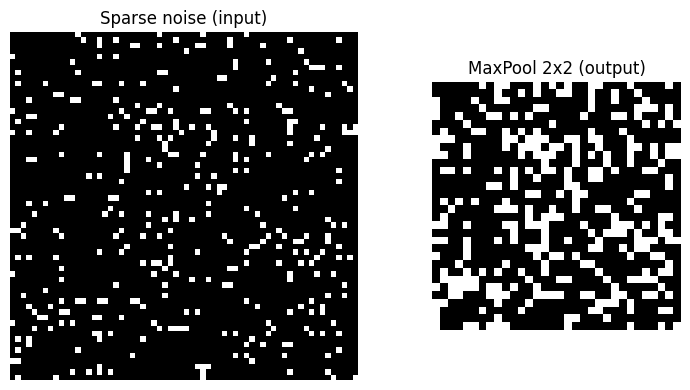

[Border] input=(64, 64) -> pooled=(32, 32)


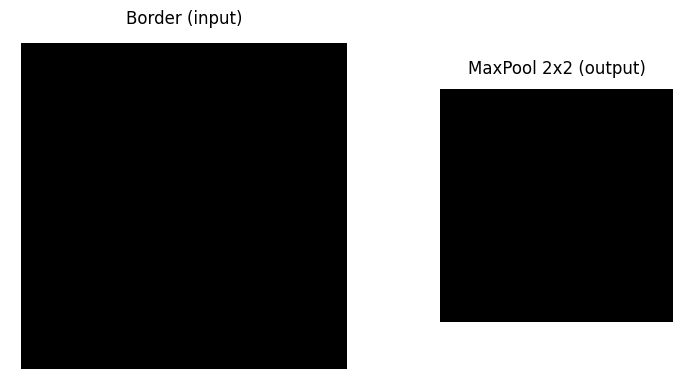

[Diag stripes] input=(64, 64) -> pooled=(32, 32)


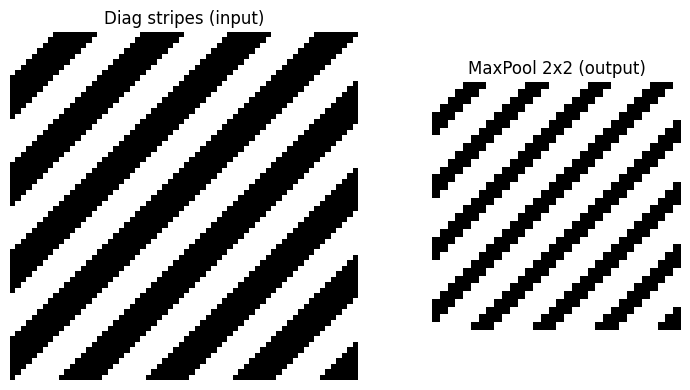

In [3]:
pool = nn.MaxPool2d(2, 2)
for name, im in imgs.items():
    y = pool(im.unsqueeze(0).unsqueeze(0))[0, 0]
    print(f'[{name}] input={tuple(im.shape)} -> pooled={tuple(y.shape)}')
    show_pair_native(im, y, f'{name} (input)', 'MaxPool 2x2 (output)')

### Experiment: kernel-uri și stride-uri diferite

In [7]:
# Exercise 1 - Run maxpooling with different kernel and stride
# Exercise 2 - Replace maxpooling with average pooling
# Question 1 - What are the advantages of maxpooling and  the advanteges of avgpooling
# Question 2 - What layer can replace pooling operations?

## Batch Normalization

### Resurse:
- [BatchNorm2d PyTorch Documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)
- [BN Visual Explanation](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739/)

### **BatchNorm2d**

**Batch Normalization** normalizează activările pe fiecare **canal** dintr-un mini-batch, astfel încât:
- media ≈ **0**  
- deviația standard ≈ **1**

Formula pentru un canal $c$ este:

$$
\mathrm{BN}(x_{i,c}) \;=\; \gamma_c \cdot \frac{x_{i,c}-\mu_c}{\sqrt{\sigma_c^{2}+\varepsilon}} \;+\; \beta_c
$$

unde:
- $x_{i,c}$ = valoarea pentru pixelul $i$ din canalul $c$  
- $\mu_c$, $\sigma_c^2$ = media și varianța pe întreg batch-ul pentru canalul $c$  
- $\epsilon$ = constantă mică pentru stabilitate numerică  
- **$\gamma_c$** (gamma) = parametru învățat care scalează canalul  
- **$\beta_c$** (beta) = parametru învățat care deplasează canalul  

---

#### 🎯 Rolul lui $\gamma$ și $\beta$
- Dacă $\gamma = 1$ și $\beta = 0$ → obținem pur și simplu standardizare clasică.  
- Dacă rețeaua ar vrea distribuția inițială, poate să învețe valori corespunzătoare pentru $\gamma, \beta$.  
- BatchNorm permite rețelei să învețe distribuția ideală pentru următorul layer
- Astfel, BN nu "restricționează" rețeaua, ci îi oferă **flexibilitate** după normalizare.

---

#### ✅ Avantaje
- **Stabilizează antrenarea**: gradientele nu devin prea mari sau prea mici.  
- **Accelerează convergența**: putem folosi rate de învățare mai mari.  
- **Regularizare**: introduce un efect de regularizare prin normalizarea pe batch-uri diferite, reducând overfitting-ul.  

#### ⚠️ Dezavantaje
- Depinde de dimensiunea batch-ului: pentru batch-uri foarte mici, statisticile (mean/var) pot fi instabile.  
- În faza de inferență trebuie folosite **statistici mediate** (running mean/var) adunate în timpul antrenării → poate crea probleme dacă distribuția datelor de test diferă de cea de train.  
- Adaugă un mic overhead computațional și doi parametri în plus per canal.



In [8]:
# Simulăm un batch de 4 imagini cu 3 canale (valori variate)
xb = torch.randn(4, 3, 32, 32) * 10 + 5  # mean~5, std~10 (dispersie mare)
print('Media pe canale (inainte de BN):', xb.mean(dim=(0,2,3)))
print('Std pe canale (inainte de BN):  ', xb.std(dim=(0,2,3)))

bn = nn.BatchNorm2d(3)  # modul train implicit
yb = bn(xb)
print('Media pe canale (dupa BN):     ', yb.mean(dim=(0,2,3)))
print('Std pe canale (dupa BN):       ', yb.std(dim=(0,2,3)))

Media pe canale (inainte de BN): tensor([4.8524, 4.8538, 5.0871])
Std pe canale (inainte de BN):   tensor([10.0830, 10.1623,  9.9895])
Media pe canale (dupa BN):      tensor([-2.7940e-09,  3.2596e-09, -9.7789e-09], grad_fn=<MeanBackward1>)
Std pe canale (dupa BN):        tensor([1.0001, 1.0001, 1.0001], grad_fn=<StdBackward0>)


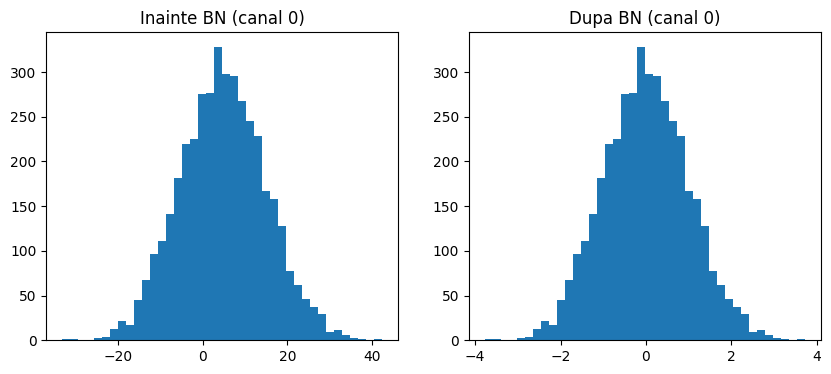

In [9]:
import matplotlib.pyplot as plt

ch = 0
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.hist(xb[:,ch].flatten().numpy(), bins=40); plt.title('Inainte BN (canal 0)')
plt.subplot(1,2,2); plt.hist(yb[:,ch].flatten().detach().numpy(), bins=40); plt.title('Dupa BN (canal 0)')
plt.show()

In [ ]:
# Exercitiu 3 - Adaugă BatchNorm2d între un Conv2d și un ReLU și observă numericele (mean/std) înainte vs. după BN.
# Exercitiu 4 - Comută modulul bn.eval() și observă că folosește running stats (nu batch stats).

In [10]:
# E3

# E4



Mean z (pre-BN):    tensor([-0.2106, -0.1678,  1.6315], grad_fn=<MeanBackward1>)
Std  z (pre-BN):    tensor([2.6531, 2.8771, 2.7693], grad_fn=<StdBackward0>)
Mean z_bn (post-BN): tensor([-8.7311e-10,  1.9209e-09,  9.3132e-09], grad_fn=<MeanBackward1>)
Std  z_bn (post-BN): tensor([1.0001, 1.0001, 1.0001], grad_fn=<StdBackward0>)
BN in modul eval (foloseste running stats). Mean: tensor([-0.1497, -0.1149,  1.1373], grad_fn=<MeanBackward1>)


In [ ]:
# (optional) Exercitiu 5 - (Construieste un pipeline pentru o problema de clasificare. Antreneaza modelul cu si fara batchnorm, documenteaza care merge mai bine)

## **Upsampling (interpolare)**

**Upsampling** este operația prin care creștem dimensiunea unei imagini sau a unui feature map.  
În rețele neuronale, upsampling-ul se folosește frecvent în **autoencodere**, **segmentation networks (ex. U-Net)** sau **GAN-uri** pentru a reconstrui imagini la rezoluție mai mare.

PyTorch oferă funcția `torch.nn.functional.interpolate`, unde poți alege diverse metode:

- **Nearest-neighbor (cel mai apropiat vecin)**  
  → copiază valorile pixelilor; simplu, dar produce margini pătrățoase.  
- **Bilinear / Bicubic**  
  → face o interpolare lină între pixeli; rezultatul e mai “neted”.  
- **Trilinear** (pentru 3D).

Formula generală pentru bilinear (2D):

$$
I(x,y) = \sum_{i,j} w_{ij}(x,y) \cdot I(i,j)
$$

unde $w_{ij}$ sunt coeficienții de interpolare (ponderi în funcție de distanță).

---

#### ✅ Avantaje
- Ușor de implementat, rapid.  
- Nu introduce parametri de învățat (operație deterministă).  
- Bun pentru reconstrucții simple

#### ⚠️ Dezavantaje
- Nu poate învăța să adauge texturi noi.  
- Poate produce imagini **blur** (bilinear/bicubic) sau **artefacte** (nearest).  

---

#### 📚 Resurse
- [PyTorch Interpolate Docs](https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html)
- [PyTorch Upsample Docs](https://docs.pytorch.org/docs/stable/generated/torch.nn.Upsample.html)


## **Transposed Convolution (ConvTranspose2d)**

**Convoluția transpusă** (sau *deconvolution*) este o operație care inversează efectul unei convoluții, permițând creșterea rezoluției unui feature map.  
Este folosită pentru **upsampling învățat**: în loc să alegem o metodă fixă (bilinear/nearest), rețeaua învață kernel-urile care reconstruiesc cel mai bine imaginea.


---

#### 🔹 Cum funcționează
- O convoluție obișnuită reduce dimensiunile (sau le păstrează).  
- **ConvTranspose2d** inversează această operație: multiplică și "extinde" valorile de intrare, aplicând kernel-uri învățate.  
- Dimensiunea de ieșire depinde de **stride, padding, kernel_size și output_padding**.


#### ✅ Avantaje
- Operație **parametrică**: poate învăța cum să reconstruiască detalii mai fidele decât interpolarea simplă.  
- Folosită în **GAN-uri** (ex. DCGAN) pentru generarea de imagini, și în semantic segmentation

#### ⚠️ Dezavantaje
- Poate introduce **artefacte tip “checkerboard”** dacă stride și kernel_size nu sunt alese atent.  
- Mai costisitoare decât upsampling-ul simplu.  
- Necesită mai multe date pentru a învăța kernel-uri bune.

---

#### 📚 Resurse
- [PyTorch ConvTranspose2d Docs](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)   
- [Distill.pub – Checkerboard Artifacts](https://distill.pub/2016/deconv-checkerboard/)  
- [CS231n - Transposed Convolutions](https://cs231n.github.io/convolutional-networks/#deconv)  


In [ ]:
# (optional) Exercitiu 6 - (Construieste un pipeline pentru o problema de segmentare. Antreneaza modelul cu Upsample si cu Conv2DTransposed, documenteaza care merge mai bine)